<a href="https://colab.research.google.com/github/Jarvis017/Sentiment-Analysis-on-Amazon-Reveiw/blob/main/Sentiment_Analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraires

In [ ]:
import pandas as pd
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
import re
from nltk.sentiment.util import *
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import numpy as np
import string
from  nltk.stem import SnowballStemmer
nltk.download('words')
nltk.download('punkt')
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras import layers
from keras import optimizers
import torch
import matplotlib.pyplot as plt
from keras import Sequential
from torch.utils.data import TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# PreProcessing

## Load the Dataset

In [ ]:
df = pd.read_csv('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Watches_v1_00.tsv.gz',on_bad_lines = 'skip',sep='\t')

In [ ]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [ ]:
df. shape

(960204, 15)

## Drop unwanted column

In [ ]:
df.drop(['marketplace','customer_id','review_id','product_id','product_parent','product_title','product_category','helpful_votes',	'total_votes',	'vine','verified_purchase','review_date'	], inplace = True,axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   star_rating      960204 non-null  int64 
 1   review_headline  960197 non-null  object
 2   review_body      960056 non-null  object
dtypes: int64(1), object(2)
memory usage: 22.0+ MB


In [ ]:
np.sum(df.isnull().any(axis=1))

155

In [ ]:
print(df.isnull().any(axis=1))

0         False
1         False
2         False
3         False
4         False
          ...  
960199    False
960200    False
960201    False
960202    False
960203    False
Length: 960204, dtype: bool


In [ ]:
df.isna().any()

star_rating        False
review_headline     True
review_body         True
dtype: bool

In [ ]:
nan_in_col  = df[df['review_headline'].isna()]

In [ ]:
print(nan_in_col)

        star_rating review_headline  \
238363            1             NaN   
347249            1             NaN   
497388            3             NaN   
525240            3             NaN   
525400            2             NaN   
555184            3             NaN   
855490            1             NaN   

                                              review_body  
238363  It is really big and heavy but I liked it a lo...  
347249                                I didn't order this  
497388  I am always searching for things on Amazon.ca ...  
525240  Well it was for a gift so I do not know if the...  
525400  I bought this watch for my daughter and when i...  
555184  Pretty but not as pretty as I thought it would...  
855490  I was looking to purchase a men's watch, but a...  


## Drop NaN column

In [ ]:
df.dropna(inplace = True)
df.reset_index(inplace=True)

In [ ]:
np.sum(df.isnull().any(axis=1))

0

In [ ]:
df.isna().any()

index              False
star_rating        False
review_headline    False
review_body        False
dtype: bool

In [ ]:
df['review_headline']=df['review_headline'].str.lower()
df['review_headline'].tail()

960044                 great prize - but size??
960045                     a very classy watch!
960046                    this is a great watch
960047                  now watt a minute here.
960048    1/10 watt difference for hearing aids
Name: review_headline, dtype: object

## Convert star ratings to Posetive, Negative and Neutral

In [ ]:
star_rating = np.array(df['star_rating'])
rev_class = np.empty_like(star_rating)
for i  in range(len(rev_class)):
  if star_rating[i] >= 4:
    rev_class[i] = 2  # class1 : Pos Class
  elif star_rating[i] <= 2:
    rev_class[i] = 0  # class2 : Neg class
  elif star_rating[i] == 3:
    rev_class[i] = 1  # class3 : Neutral class

df['star_rating'] = rev_class

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TAG_RE = re.compile(r'<[^>]+>')
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = TAG_RE.sub('', text)
    #text = re.sub(html_tags_cleaner,' ',str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.head(50)

,index,star_rating,review_headline,review_body
0,0,2,five stars,Absolutely love this watch! Get compliments al...
1,1,2,i love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.
2,2,0,two stars,Scratches
3,3,2,five stars,"It works well on me. However, I found cheaper ..."
4,4,2,"beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...
5,5,2,no complaints,"i love this watch for my purpose, about the pe..."
6,6,2,five stars,"for my wife and she loved it, looks great and ..."
7,7,0,i was about to buy this thinking it was a ...,I was about to buy this thinking it was a Swis...
8,8,2,perfect watch!,Watch is perfect. Rugged with the metal &#34;B...
9,9,2,great quality and build,Great quality and build.<br />The motors are r...


In [ ]:
df['review_headline'] = df['review_headline'].apply(lambda x: preprocess(x))

In [ ]:
df['review_body'] = df['review_body'].apply(lambda x: preprocess(x))

In [ ]:
df.head(50)

In [ ]:
words = set(nltk.corpus.words.words())
def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in words or not w.isalpha())

df['review_body'] = df['review_body'].apply(clean_sent)


In [ ]:
df.head(50)

In [ ]:
headline = df['review_headline'].to_list()[:20000]
body = df['review_body'].to_list()[:20000]
rate = df['star_rating'].to_list()[:20000]

In [ ]:
tk = Tokenizer(
    num_words=1000,
    #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    split=' ',
    oov_token='UNK'
)
tk.fit_on_texts(headline)
tk.fit_on_texts(body)

In [ ]:
X_h = tk.texts_to_sequences(headline)
X_b = tk.texts_to_sequences(body)
X_h[0]

In [ ]:
max_len = max([len(hs.split()) for hs in headline])
max_len_body = max([len(bs.split()) for bs in body])
print(max_len)
print(max_len_body)

In [ ]:
Xh_pad1 = pad_sequences(X_h, maxlen=20, padding='post')
Xh_pad1.shape

In [ ]:
Xb_pad1 = pad_sequences(X_b, maxlen=20, padding='post')
Xb_pad1.shape

In [ ]:
Xh_pad1.shape

In [ ]:
Xb_pad1

In [ ]:
Xh_OH = to_categorical(Xh_pad1)
Xh_OH.shape

In [ ]:
Xh_Ob = to_categorical(Xb_pad1)
Xh_Ob.shape

In [ ]:
labels = to_categorical(rate,num_classes = 3)

In [ ]:
X1_train, X2_train, Y_train, Y_test = train_test_split(Xh_OH, labels,test_size=0.2)

In [ ]:
X1_train.shape,Y_train.shape

# Keras Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout
model = Sequential()
model.add(layers.Input(shape=X1_train.shape[1:]))
model.add(layers.LSTM(128,return_sequences = True))
model.add(layers.LSTM(64))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['categorical_accuracy'])
print(model.summary())

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(X1_train, Y_train , epochs=20,validation_split = 0.2)

## Plotting

# **BERT**



In [ ]:

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00


## Load BertTokenizer

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
for sentence in df['review_body'][:10000]:
  print(sentence)

Streaming output truncated to the last 5000 lines.
It is too diferent, not like a photo.  Can I return?
I like it. Everyone noticed it
I love this watch. From the quality of materials it was built and the functionality. It was superb.
This is a fantastic watch for the money. My 7 year old son just loves it.
I love this watch!  I Bought it for clinicals because I need a watch that can withstand a lot of handwashing and this one is water resistant to 100 meters, which means you can go swimming and snorkeling with it. It's functional, has the perfect size, matches with everything, and pretty to look at!  I love it!
Great watch, good feel and accurate
I like it / I get several compliments about the watch.  Only downside - it is very heavy.
Very good quality.  I wear this all the time now.<br />I don't see a lot of people wearing these kind of watches now. It's definitely something that's is classic and reliable.
Beautiful Watch!  Easy to read ! Love 2 tone color!<br />Deb G.
Nice set liked

## BERT Tokenizer

In [ ]:
input_ids = []
attention_masks = []
i = 0
number_of_data = 20000
for sent in df['review_body'][:number_of_data]:

    print(i)
    i = i + 1
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['star_rating'][:number_of_data])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Streaming output truncated to the last 5000 lines.
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
1

## Data Splitting

In [ ]:

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = 0.6
val_size = 0.2
test_size = 0.2

# Divide the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


## Making Dataloader

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 32


train_dataloader = DataLoader(
            train_dataset,  # training data
            sampler = RandomSampler(train_dataset), # random batches
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset, # validation data
            sampler = SequentialSampler(val_dataset), # Sequential batches
            batch_size = batch_size
        )

## Load Bert Sequence Classification

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3, # 3 Class for prediction
    output_attentions = False,
    output_hidden_states = False,
)


model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Set Optimizer

In [ ]:
from transformers import get_linear_schedule_with_warmup
optimizer = torch.optim.AdamW(model.parameters())
epochs = 4
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = epochs)

In [ ]:
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Training Loop

In [ ]:
import random

training_stats = []

# Measure the total training time for the whole run.

# For each epoch...
for epoch_i in range(0, epochs):


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}'.format(step, len(train_dataloader)))


        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()


        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)



    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))




    print("")
    print("Running Validation...")

    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():


            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)



    print("  Validation Loss: {0:.2f}".format(avg_val_loss))


    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
        }
    )

print("")
print("Training complete!")




======== Epoch 1 / 4 ========
Training...
  Batch    40  of    375
  Batch    80  of    375
  Batch   120  of    375
  Batch   160  of    375
  Batch   200  of    375
  Batch   240  of    375
  Batch   280  of    375
  Batch   320  of    375
  Batch   360  of    375

  Average training loss: 0.78

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.75

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    375
  Batch    80  of    375
  Batch   120  of    375
  Batch   160  of    375
  Batch   200  of    375
  Batch   240  of    375
  Batch   280  of    375
  Batch   320  of    375
  Batch   360  of    375

  Average training loss: 0.78

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.75

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    375
  Batch    80  of    375
  Batch   120  of    375
  Batch   160  of    375
  Batch   200  of    375
  Batch   240  of    375
  Batch   280  of    375
  Batch   320  of    375
  Batch   360  of    375

  Ave

### Report

In [ ]:
stats = pd.DataFrame(data=training_stats)
stats = stats.set_index('epoch')
stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.784292,0.751256,0.769
2,0.781644,0.751256,0.769
3,0.784102,0.751256,0.769
4,0.782906,0.751256,0.769


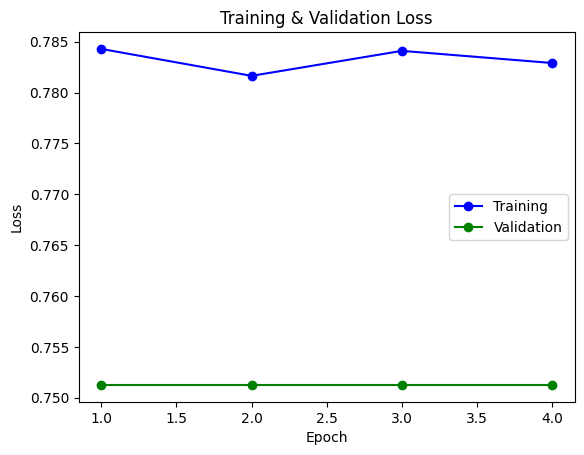

In [ ]:
plt.plot(stats['Training Loss'], 'b-o', label="Training")
plt.plot(stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Evaluate on Test

In [ ]:
test_dataloader = DataLoader(
            test_dataset, # validation data
            sampler = SequentialSampler(test_dataset), # Sequential batches
            batch_size = batch_size
        )

In [ ]:
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch


  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
acc = 0
for i in range(len(true_labels)):
  acc += accuracy(predictions[i], true_labels[i])
print(acc/len(true_labels))
print('    DONE.')

0.773
    DONE.


# **Bert Embedding**

In [ ]:
!pip install transformers

## Load BERT Word Embeddings

In [ ]:
import transformers
bert = transformers.BertModel.from_pretrained('bert-base-uncased')
bert_embeddings = list(bert.children())[0]
bert_word_embeddings = list(bert_embeddings.children())[0]
bert_word_embeddings = bert_word_embeddings.weight.data.numpy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_word_embeddings.shape[0],bert_word_embeddings.shape[1]

(30522, 768)

## Tokenizing Sentences

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return padded_text
train_indices = tokenize_and_pad_text(df['review_body'][:15000], 20)


Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


## Model with BERT Embedding

In [ ]:
embedding_layer =layers.Embedding(bert_word_embeddings.shape[0],
                                  bert_word_embeddings.shape[1],
                                  weights = [bert_word_embeddings],
                                  input_length = 20,
                                  trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(layers.LSTM(128,return_sequences = True))
model.add(layers.LSTM(64))
model.add(layers.Dense(3, activation='softmax'))
opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 768)           23440896  
                                                                 
 lstm (LSTM)                 (None, 20, 128)           459264    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 23,949,763
Trainable params: 508,867
Non-trainable params: 23,440,896
_________________________________________________________________


In [ ]:
y =to_categorical(df['star_rating'][:15000],num_classes = 3)
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_indices, y , epochs=10,validation_split = 0.2)

Epoch 1/10
375/375 [==============================] - 17s 20ms/step - loss: 0.5742 - categorical_accuracy: 0.7967 - val_loss: 0.4791 - val_categorical_accuracy: 0.8263
Epoch 2/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4648 - categorical_accuracy: 0.8333 - val_loss: 0.4887 - val_categorical_accuracy: 0.8167
Epoch 3/10
375/375 [==============================] - 5s 13ms/step - loss: 0.4340 - categorical_accuracy: 0.8407 - val_loss: 0.4514 - val_categorical_accuracy: 0.8313
Epoch 4/10
375/375 [==============================] - 5s 15ms/step - loss: 0.4190 - categorical_accuracy: 0.8432 - val_loss: 0.4702 - val_categorical_accuracy: 0.8193
Epoch 5/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4033 - categorical_accuracy: 0.8500 - val_loss: 0.4408 - val_categorical_accuracy: 0.8317
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.3806 - categorical_accuracy: 0.8576 - val_loss: 0.4430 - val_categorical_accuracy: 0.83

### Report

In [ ]:
y_pred =  model.predict(train_indices)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = to_categorical(y_pred)
print(classification_report(y, y_pred))

469/469 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      2228
           1       0.55      0.22      0.32      1179
           2       0.93      0.95      0.94     11593

   micro avg       0.88      0.88      0.88     15000
   macro avg       0.73      0.67      0.67     15000
weighted avg       0.87      0.88      0.87     15000
 samples avg       0.88      0.88      0.88     15000

